In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [76]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
data_dir = '~/aiffel/kaggle_kakr_housing/data'
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [95]:
test.shape

(6468, 20)

In [93]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   bedrooms       15035 non-null  int64  
 3   bathrooms      15035 non-null  float64
 4   sqft_living    15035 non-null  int64  
 5   sqft_lot       15035 non-null  int64  
 6   floors         15035 non-null  float64
 7   waterfront     15035 non-null  int64  
 8   view           15035 non-null  int64  
 9   condition      15035 non-null  int64  
 10  grade          15035 non-null  int64  
 11  sqft_above     15035 non-null  int64  
 12  sqft_basement  15035 non-null  int64  
 13  yr_built       15035 non-null  int64  
 14  yr_renovated   15035 non-null  int64  
 15  zipcode        15035 non-null  int64  
 16  lat            15035 non-null  float64
 17  long           15035 non-null  float64
 18  sqft_l

## 데이터 변수들 설명
    - ID:집을 구분하는 번호
    - date: 집을 구매한 날짜
    - price: 집의 가격(Target variable)
    - bedrooms: 침실의 수
    - bathrooms: 화장실의 수
    - sqft_living: 주거 공간의 평방 피트(면적)
    - sqft_lot: 부지의 평방 피트(면적)
    - floors: 집의 층 수
    - waterfront: 집의 전방에 강이 흐르는지 유무(a.k.a 리버뷰)
    - view: has been viewed
    - condition: 집의 전반적인 상태
    - grade: King County grading: 시스템 기준으로 매긴 집의 등급
    - sqft_above: 지하철을 제외한 평방 피트(면적)
    - sqft_basement: 지하실의 평방 피트(면적)
    - yr_built : 지어진 년도
    - yr_renovated: 집을 재건축한 년도
    - zipcode: 우편번호
    - lat: 위도
    - long: 경도
    - sqft_living15: 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
    - sqft_lot15: 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면 변화가 있을 수 있음)
    

## 타겟변수 price 분포 확인

In [56]:
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

### Min과 Max의 차이로 인해 데이터를 자세히 살펴봄

<AxesSubplot:xlabel='price', ylabel='Density'>

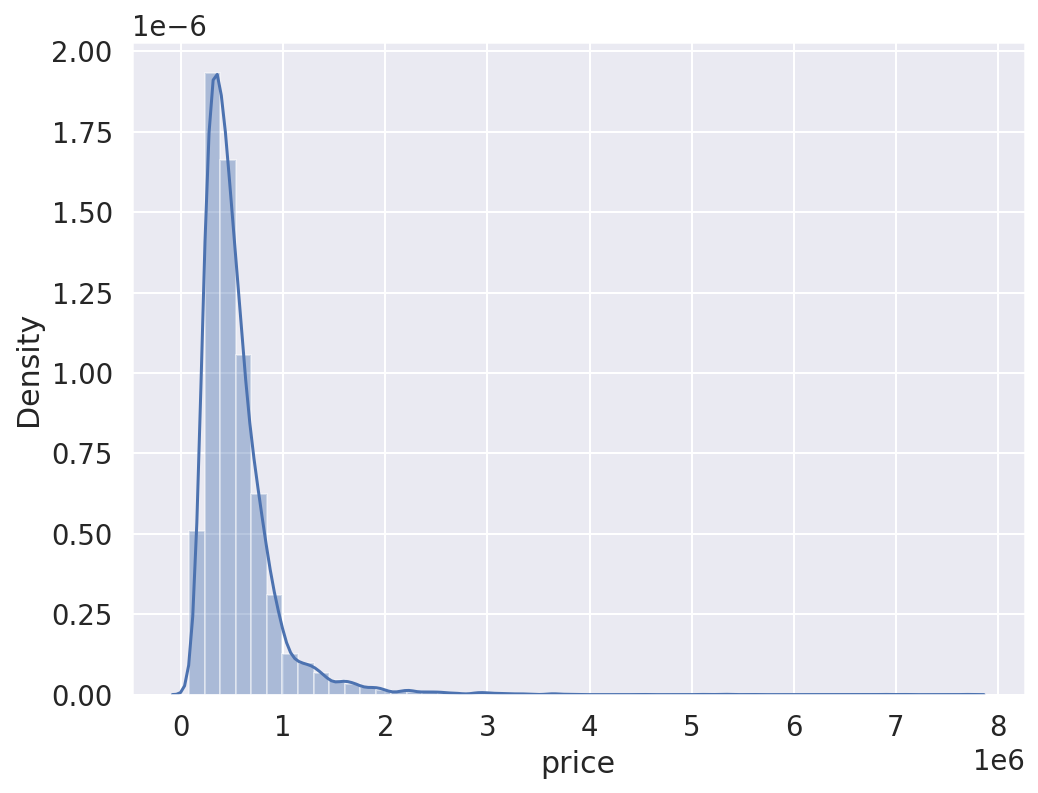

In [57]:
f, ax = plt.subplots(figsize=(8,6))
sns.distplot(train['price'])

<AxesSubplot:xlabel='price', ylabel='Density'>

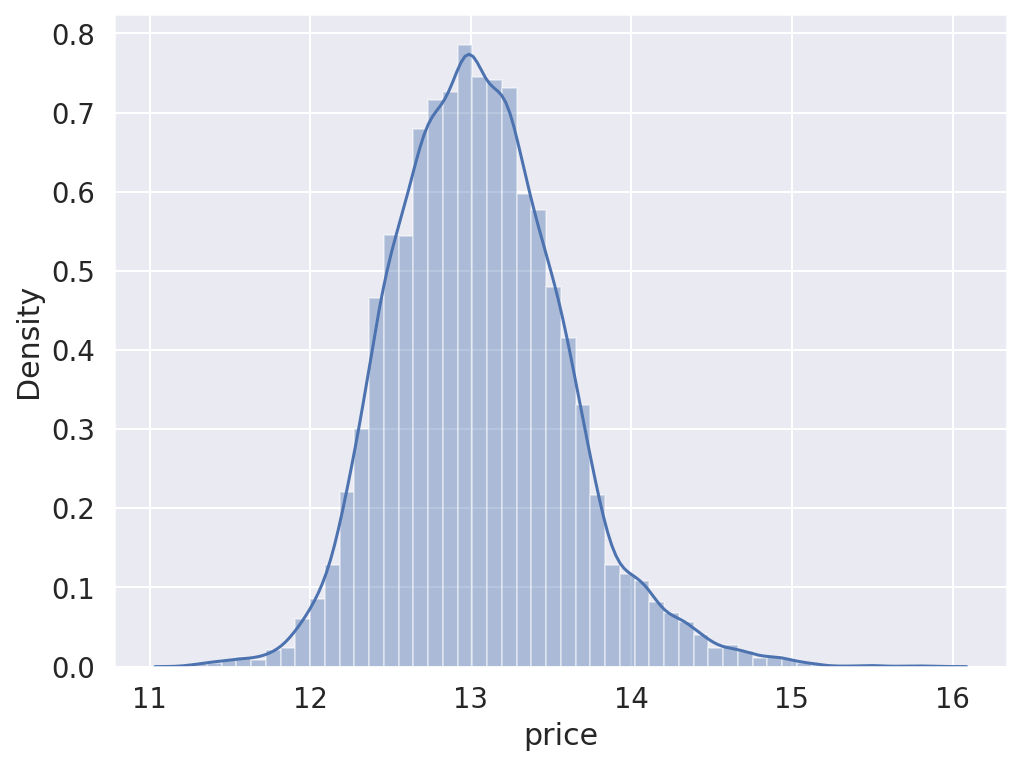

In [58]:
train['price'] = np.log1p(train['price'])

f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

In [59]:
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

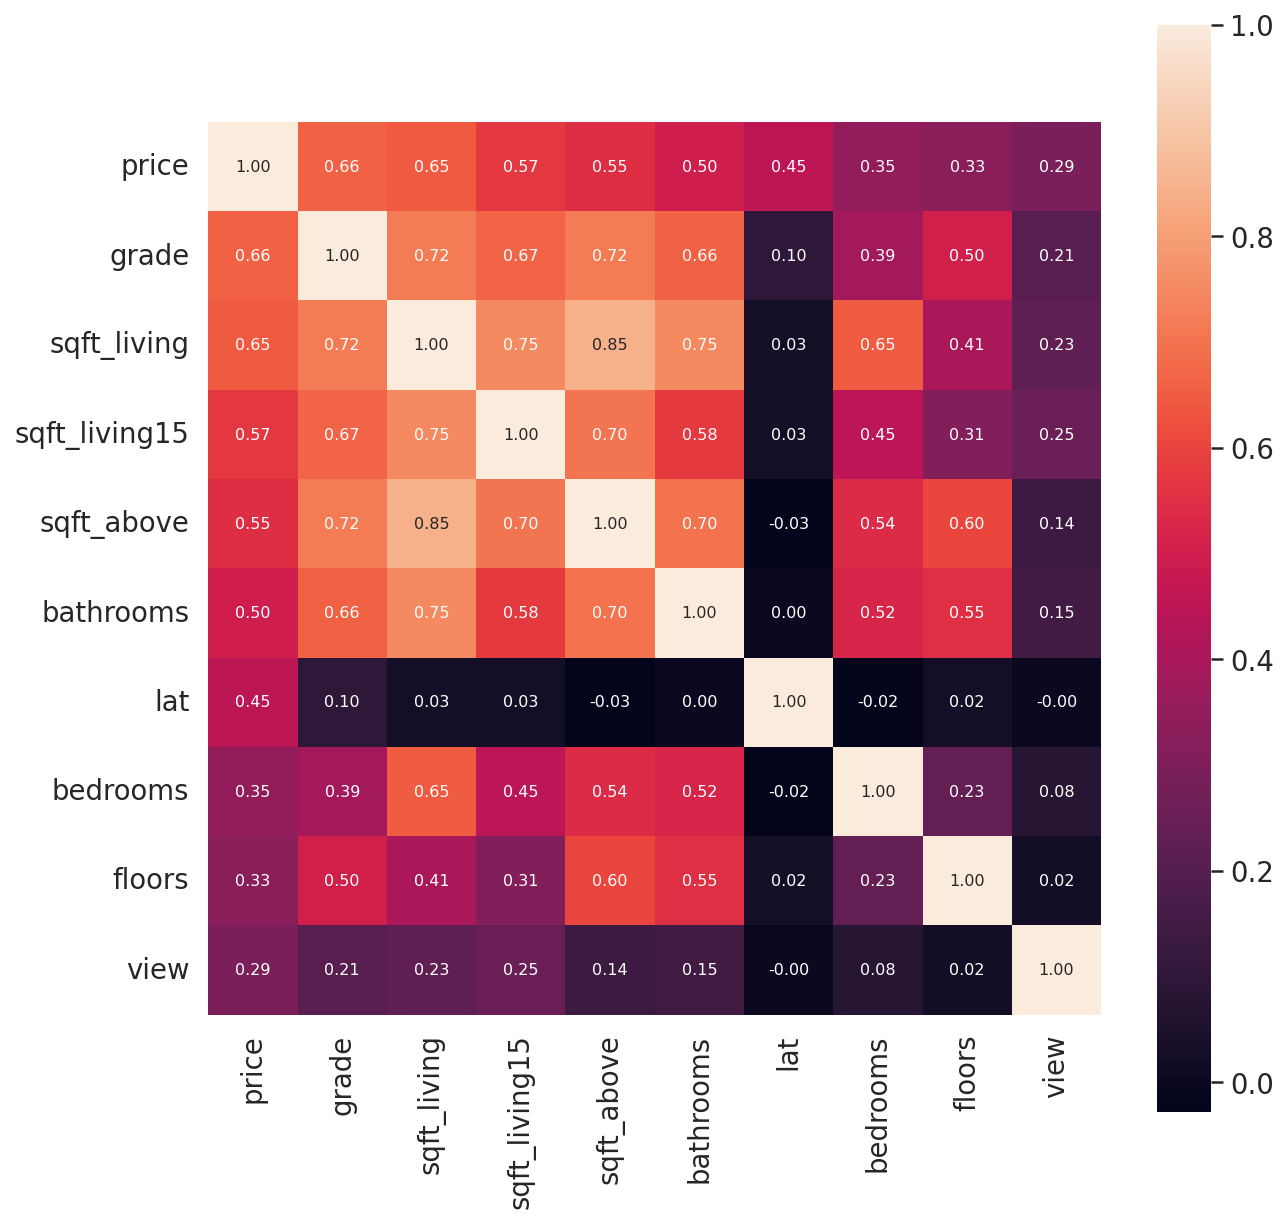

In [60]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [96]:
y = train['price']
del train['price']

In [91]:
len(train)

15035

In [62]:
train_len = len(train)
train = pd.concat((train, test), axis=0)
print(len(train))

21503


In [63]:
sub_id = train['id'][train_len:]
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [97]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


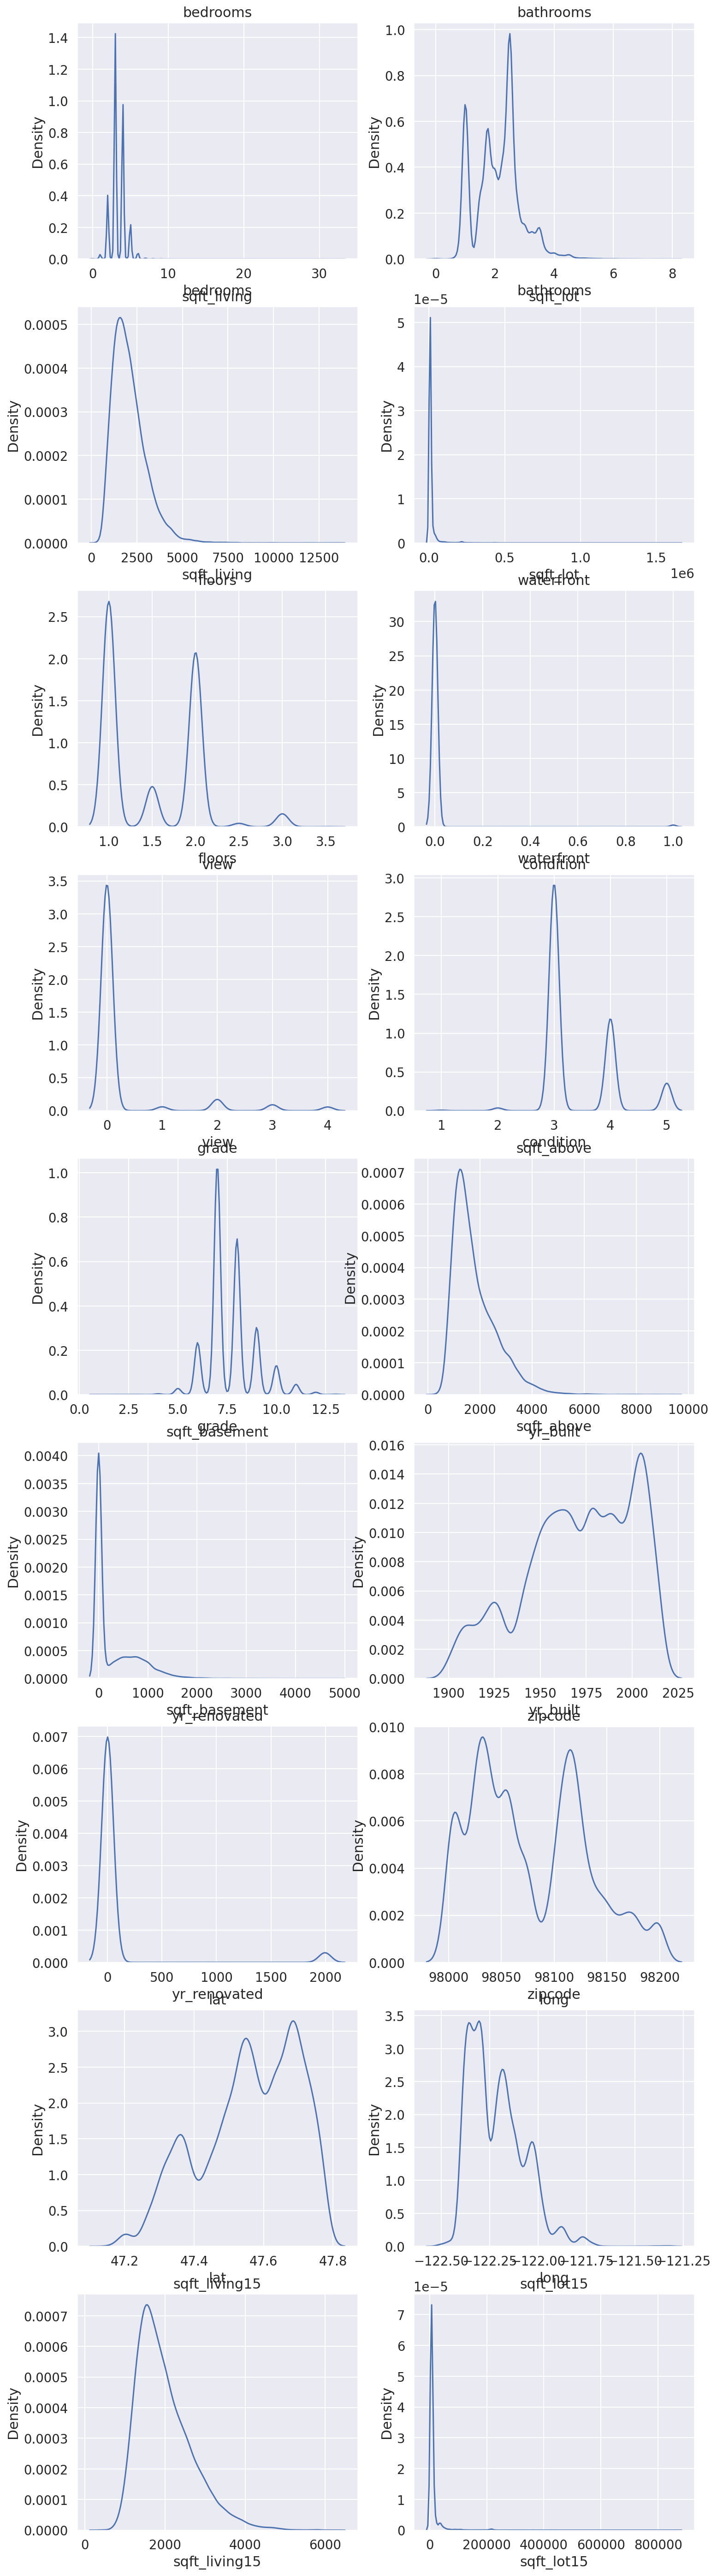

In [65]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

In [66]:
skew_columns = ['bedrooms','sqft_living','sqft_lot','sqft_above','sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

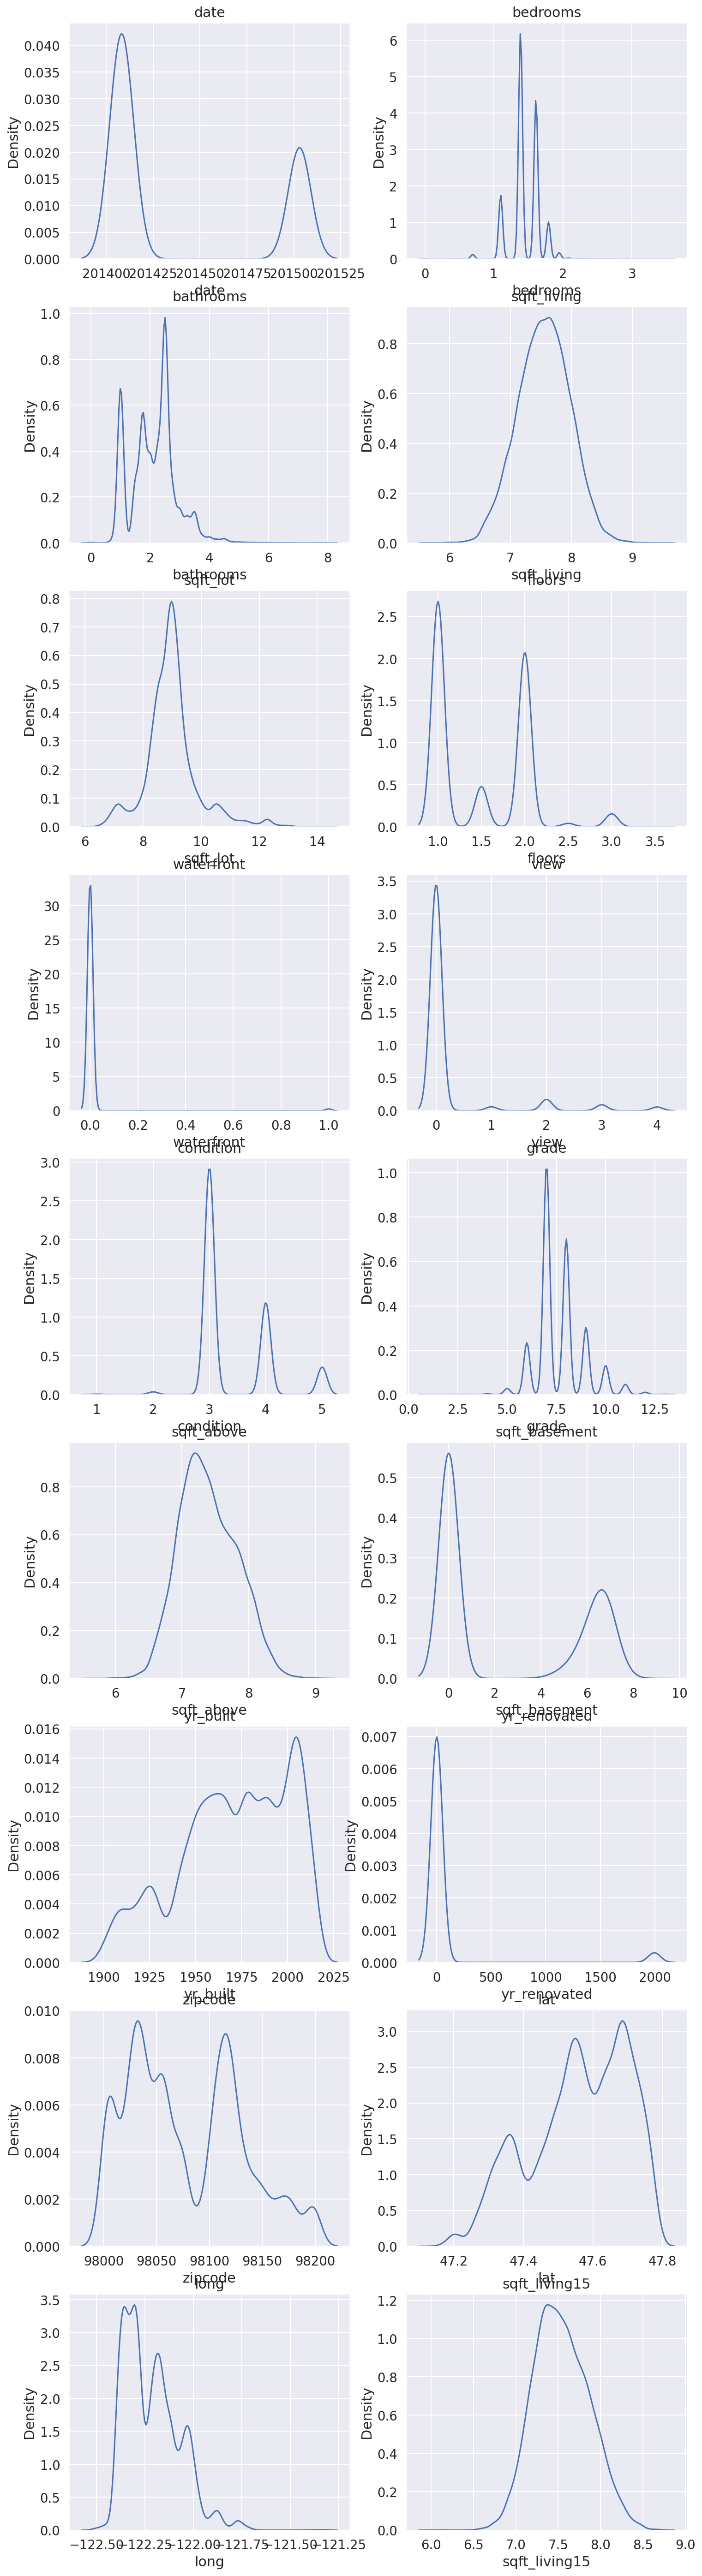

In [67]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))
count = 0
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightbgm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightbgm, rdforest]

In [82]:
def  get_scores(models, x, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df


In [83]:
def my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',
                              cv=5, verbose=1, n_jobs=5)
    
    grid_model.fit(x, y)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1*results['score'])
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE', ascending=True)
    
    return results

In [84]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = ('~/aiffel/Ex02_KaKR/')
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [87]:
param_grid = {
    'n_estimators': [50, 100, 150, 200,250,300],
    'max_depth': [1, 5, 10, 15, 20,25,30],
}

In [98]:
model = LGBMRegressor(random_state=random_state)
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 5, 10, 15, 20, 25, 30],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [101]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 1, 'n_estimators': 150},
 {'max_depth': 1, 'n_estimators': 200},
 {'max_depth': 1, 'n_estimators': 250},
 {'max_depth': 1, 'n_estimators': 300},
 {'max_depth': 5, 'n_estimators': 50},
 {'max_depth': 5, 'n_estimators': 100},
 {'max_depth': 5, 'n_estimators': 150},
 {'max_depth': 5, 'n_estimators': 200},
 {'max_depth': 5, 'n_estimators': 250},
 {'max_depth': 5, 'n_estimators': 300},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 150},
 {'max_depth': 10, 'n_estimators': 200},
 {'max_depth': 10, 'n_estimators': 250},
 {'max_depth': 10, 'n_estimators': 300},
 {'max_depth': 15, 'n_estimators': 50},
 {'max_depth': 15, 'n_estimators': 100},
 {'max_depth': 15, 'n_estimators': 150},
 {'max_depth': 15, 'n_estimators': 200},
 {'max_depth': 15, 'n_estimators': 250},
 {'max_depth': 15, 'n_estimators': 300},
 {'max_depth': 20, 'n_estimators

In [102]:
score = grid_model.cv_results_['mean_test_score']
score

array([-4.79031133e+10, -3.85670747e+10, -3.48582574e+10, -3.28977076e+10,
       -3.16513603e+10, -3.07697495e+10, -1.87686640e+10, -1.71929229e+10,
       -1.65852629e+10, -1.61470658e+10, -1.57279493e+10, -1.55221449e+10,
       -1.74157131e+10, -1.65592880e+10, -1.63763100e+10, -1.64495651e+10,
       -1.64772277e+10, -1.65082112e+10, -1.73071044e+10, -1.63958448e+10,
       -1.63412104e+10, -1.63495863e+10, -1.64175408e+10, -1.65016831e+10,
       -1.73137515e+10, -1.63953204e+10, -1.62942827e+10, -1.63117449e+10,
       -1.63543744e+10, -1.64801299e+10, -1.73137515e+10, -1.63953204e+10,
       -1.62942827e+10, -1.63133602e+10, -1.63332232e+10, -1.64259261e+10,
       -1.73137515e+10, -1.63953204e+10, -1.62942827e+10, -1.63133602e+10,
       -1.63332232e+10, -1.64259261e+10])

In [103]:
results = pd.DataFrame(params)
results['score'] = score
results

,max_depth,n_estimators,score
0,1,50,-4.790311e+10
1,1,100,-3.856707e+10
2,1,150,-3.485826e+10
3,1,200,-3.289771e+10
4,1,250,-3.165136e+10
5,1,300,-3.076975e+10
6,5,50,-1.876866e+10
7,5,100,-1.719292e+10
8,5,150,-1.658526e+10
9,5,200,-1.614707e+10


In [104]:
results['RMSE'] = np.sqrt(-1*results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-4.790311e+10,218867.798643
1,1,100,-3.856707e+10,196385.016448
2,1,150,-3.485826e+10,186703.662056
3,1,200,-3.289771e+10,181377.252149
4,1,250,-3.165136e+10,177908.291837
5,1,300,-3.076975e+10,175413.082514
6,5,50,-1.876866e+10,136998.773838
7,5,100,-1.719292e+10,131121.786689
8,5,150,-1.658526e+10,128783.783529
9,5,200,-1.614707e+10,127071.105097


In [105]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-4.790311e+10,218867.798643
1,1,100,-3.856707e+10,196385.016448
2,1,150,-3.485826e+10,186703.662056
3,1,200,-3.289771e+10,181377.252149
4,1,250,-3.165136e+10,177908.291837
5,1,300,-3.076975e+10,175413.082514
6,5,50,-1.876866e+10,136998.773838
7,5,100,-1.719292e+10,131121.786689
8,5,150,-1.658526e+10,128783.783529
9,5,200,-1.614707e+10,127071.105097


In [106]:
results = results.sort_values('RMSLE', ascending=True)
results

,max_depth,n_estimators,score,RMSLE
11,5,300,-1.552214e+10,124587.900185
10,5,250,-1.572795e+10,125411.121291
9,5,200,-1.614707e+10,127071.105097
38,30,150,-1.629428e+10,127649.060704
26,20,150,-1.629428e+10,127649.060704
32,25,150,-1.629428e+10,127649.060704
27,20,200,-1.631174e+10,127717.441686
39,30,200,-1.631336e+10,127723.765068
33,25,200,-1.631336e+10,127723.765068
40,30,250,-1.633322e+10,127801.499022


In [107]:
data_dir =  os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [108]:
submission['price'] = prediction
submission.head()

NameError: name 'prediction' is not defined

In [99]:
#grid_model.cv_results_
best_params = grid_model.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 5, 'n_estimators': 300}


In [143]:
if 'id' in test.columns:
    del test['id']

In [148]:
best_model = grid_model.best_estimator_
best_model.fit(train,y)
prediction = best_model.predict(test)

In [149]:
prediction

array([ 488374.45111929,  430318.79791164, 1283592.43673642, ...,
        468664.78743825,  320970.66351181,  433010.25741064])

In [146]:
#prediction = np.expm1(prediction)

In [151]:
result = pd.DataFrame({
    'price' : prediction
})

result.to_csv("last.csv")